In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import ast
from metrics import testMLModel

In [2]:
df = pd.read_csv("archive/clean_IMDB3.csv")

In [3]:
tfidf = TfidfVectorizer(max_features=25000)
X_tfidf = tfidf.fit_transform(df["clean_review"])
y = df["sentiment"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
rfmodel = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfmodel.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
joblib.dump(rfmodel,"rfmodelV4.pkl")

['rfmodelV4.pkl']

In [8]:
newModel = joblib.load("modelML/rf/rfmodelV4.pkl")

In [9]:
y_pred = newModel.predict(X_test)

### Perfection des hyperparamètres

In [19]:
from sklearn.pipeline import Pipeline

df = pd.read_csv("archive/clean_IMDB3.csv")

texts = df["clean_review"].apply(ast.literal_eval).apply(lambda t: " ".join(t))
y = df["sentiment"].map({"negative":0, "positive":1}).astype(int)
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [23]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

param_dist = {
    "tfidf__max_features": [20000, 30000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__n_estimators": randint(300, 900),         # nb d’arbres
    "clf__max_depth": [None, 20, 40],               # profondeur
    "clf__min_samples_split": randint(2, 11),
    "clf__min_samples_leaf": randint(1, 6),
    "clf__max_features": ["sqrt", 0.2, 0.4],        # nb features par split
    "clf__bootstrap": [True],                       # bagging standard
    # "clf__class_weight": [None, "balanced"],      # utile si classes déséquilibrées
}

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
rand = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,                 # 30–60 = bon compromis
    scoring="accuracy",        # ou "f1", "f1_macro"
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

In [26]:
rand.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

In [ ]:
print("RandomizedSearch - Best params:", rand.best_params_)
print("RandomizedSearch - Best CV score:", rand.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [ ]:
best_model = grid.best_estimator_

Meilleurs paramètres : {'clf__max_depth': None, 'clf__n_estimators': 400, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Meilleure accuracy : 0.8629800126906378


In [ ]:
joblib.dump(best_model, "modelML/rf/rfmodelV5.pkl")
joblib.dump(grid_rf,"modelML/rf/rf_gridV5.pkl")

['rf_gridV3.pkl']

In [ ]:
modelrf = joblib.load("modelML/rf/rfmodelV5.pkl")
print(modelrf.predict(["great"]))

['positive']


Rapport de classification :
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     25000
    positive       1.00      1.00      1.00     25000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Matrice de confusion :


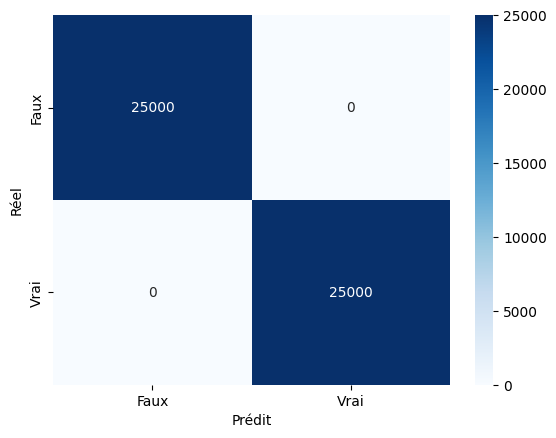

Courbe d'apprentissage :


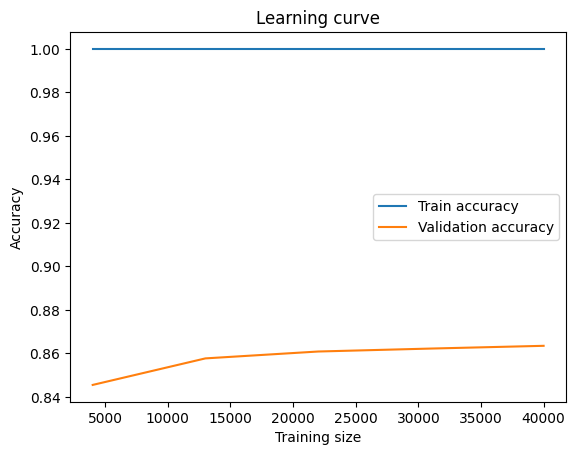

In [24]:
y_pred = modelrf.predict(X)

testMLModel(modelrf,X,y,y_pred)

In [25]:
print(grid_rf)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=20000)),
                                       ('clf',
                                        RandomForestClassifier(n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [10, None],
                         'clf__n_estimators': [200, 400],
                         'tfidf__max_features': [10000, 20000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)
